Notebook to calculate grid adjacency and do p-class clustering for Rosi's MPAS aquaplanet grid.

Also writes out a single time step of p-class values.

James Ruppert  
9/1/2025

### Main settings

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib import rc, colors
import cartopy.crs as ccrs

### Read/Write variable from MPAS output

In [ ]:
do_write = True
do_write = False

if do_write:

    import xarray as xr
    import dask.array as da
    import dask
    from precip_class_mpas import *

    grid_path = "/glade/work/rberrios/MPAS/aqua_sstmax10N_ASD/plus4K/TC_3km/x5.tropical_3km_10N.init.nc"
    grid = xr.open_dataset(grid_path)

    latCell = np.degrees(grid.latCell)
    lonCell = np.degrees(grid.lonCell)

    # def pclass_map():

    # Get list of desired file times
    file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
    file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]

    istart_set=11
    # file_times[istart_set]
    # file_times

    pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']

    exp_names = ["CTL", "HOMO_RAD", "CLIM_RAD"]
    main_path = "/glade/campaign/mmm/dpm/rberrios/glade_scratch/MPAS_APE/aqua_sstmax10N_ASD/"
    expName=exp_names[0]

    data_path = f"{main_path}{expName}/TC_3km/"

    time = file_times[20]

    wp_files = data_path+'waterPaths.'+time+'.nc'
    nCells_chunk_size = 100000
    ds = xr.open_mfdataset(wp_files,
                parallel=True, 
                chunks={"Time": -1, "nCells": nCells_chunk_size})

    q_int_dask = da.stack([
        ds.lwp.data,
        ds.iwp.data,
        ds.rwp.data,
        ds.gwp.data
    ], axis=0) # Stack along a new 0th dimension for the different water paths

    c_type_dask = precip_class_mpas(q_int_dask)
    results = dask.compute(c_type_dask)[0][0] # dask.compute returns a tuple of results

    # Write to pickle
    pickle_dir = f"/glade/derecho/scratch/ruppert/tc-crfrad/pickle_out"
    pickle_file_out = f"{pickle_dir}/pclass_{expName}_{time}.pickle"
    with open(pickle_file_out, 'wb') as f:
        # pickle.dump(PE_thisExp, f)
        pickle.dump([latCell, lonCell, results], f)

### Plot P-Class

In [2]:
# Get list of desired file times
file_times_arr = np.arange('2000-05-01T06:00:00', '2000-05-11T06:00:00', 6, dtype='datetime64[h]')
file_times = [file_times_arr[i].astype('datetime64[D]').astype(str)+'_'+str(file_times_arr[i]).split('T')[1].split(':')[0]+'.00.00' for i in range(len(file_times_arr))]

time = file_times[20]

pclass_names = ['DC', 'CG', 'SC', 'ST', 'AN', 'DSA']
exp_names = ["CTL", "HOMO_RAD", "CLIM_RAD"]
expName=exp_names[0]

# Write to pickle
pickle_file_read = f"../../../pickle_out/aquaplanet/pclass_{expName}_{time}.pickle"
# Read from pickle
with open(pickle_file_read, 'rb') as f:
    latCell, lonCell, c_type = pickle.load(f)

In [3]:
ll_bounds = (0,60,0,30)
filter = np.where((lonCell >= ll_bounds[0]) &
                  (lonCell <= ll_bounds[1]) &
                  (latCell >= ll_bounds[2]) &
                  (latCell <= ll_bounds[3]))[0]

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}
rc('font', **font)

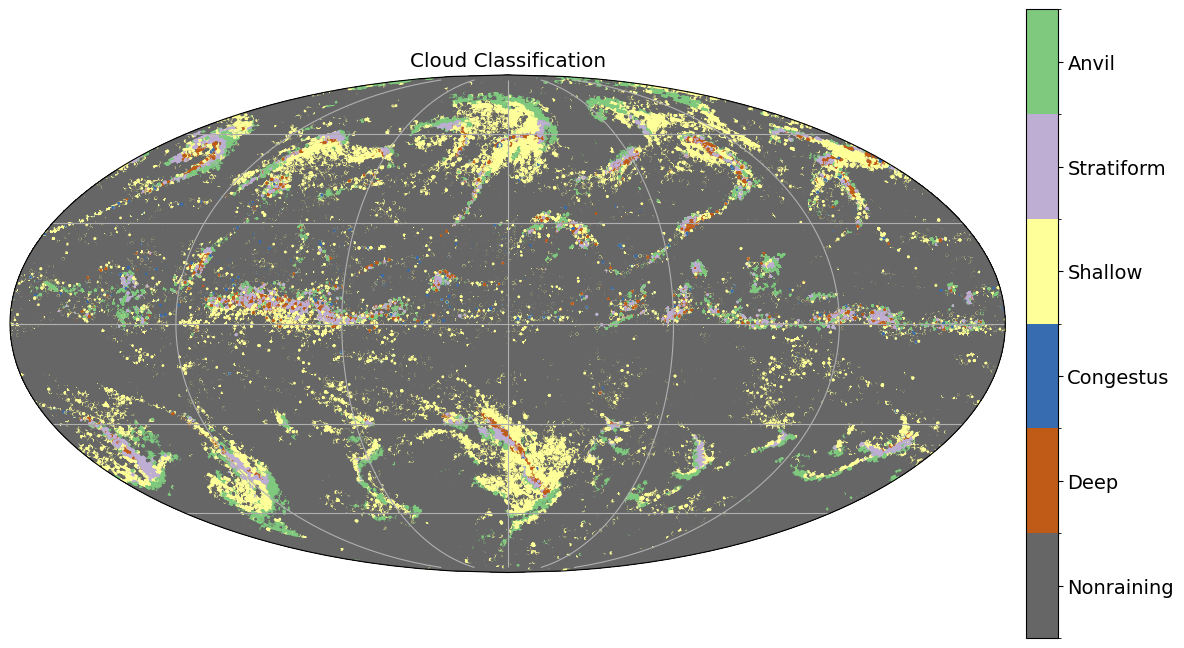

In [4]:
bounds = np.array([-0.5, .5, 1.5, 2.5, 3.5, 4.5, 5.5])
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=6)

nlevs = len(bounds) - 1
cmap = plt.get_cmap('Accent_r', nlevs)

fig = plt.figure(figsize=(12,10))
fig.set_facecolor('white')
ax = fig.add_subplot(111, projection=ccrs.Mollweide())
# ax = fig.add_subplot(111)
ax.gridlines()#draw_labels=True, x_inline=False, y_inline=False)#, dms=True)

# sc = ax.scatter(lonCell[filter], latCell[filter], c=c_type[filter], cmap=cmap, norm=norm, s=1)
sc = ax.scatter(lonCell, latCell, c=c_type, cmap=cmap, norm=norm, s=1, transform=ccrs.PlateCarree())
# sc = ax.contourf(lonCell, latCell, c=c_type, cmap=cmap, norm=norm, s=1)
# sc = ax.tricontourf(lonCell, latCell, c_type, levels=15, cmap='viridis')

cbar=plt.colorbar(sc, fraction=0.03, pad=0.02, ticks=(0,1,2,3,4,5))
cbar.set_ticklabels(['Nonraining','Deep', 'Congestus', 'Shallow', 'Stratiform', 'Anvil'])
cbar.ax.tick_params(labelsize=14)
ax.set_title("Cloud Classification")
# plt.xlim(xlim)
# plt.ylim((-5,25))

# ax.set_global()

plt.tight_layout()
# return None